# Tarea 6. Applications of Fourier analysis
Guillermo Segura Gómez

## Exercice 1 (Amplitude VS Phase).

The aim of this exercise is to determine which component in the Fourier domain of an
image contains more information about the image content : the amplitude or the phase.
1. Construct two images res1.png and res2.png such that :
- The Fourier domain of res1.png contains the amplitude of img1.png and the phase of img2.png.
- The Fourier domain of res2.png contains the amplitude of img2.png and the phase of img1.png.
2. Conclude

---

### Transformada rápida de Fourier (FFT)

La FFT (Fast Fourier Transform) es un algoritmo super eficiente para calcular la Transformada Discreta de Fourier (DFT) y su inversa. La DFT convierte una secuencia finita de números complejos o reales en una secuencia de coeficientes de frecuencia, revelando las frecuencias sinusoidales presentes en la señal original. La FFT es ampliamente utilizada porque reduce drásticamente el número de cálculos necesarios para la DFT de $N$ elementos de $O(N^2)$ a $O(N \log N)$, por lo que es bastante útil para el procesamiento de señales como las de una imagen. 

De la clase revisamos los conceptos de **amplitud** y **fase**, cruciales para poder entender este ejercicio

- **Amplitud**: La amplitud de cada componente de frecuencia indica cuán fuerte es esa frecuencia en la señal. Matemáticamente, la amplitud de un componente de frecuencia específico se calcula a partir del módulo del número complejo correspondiente en el resultado de la FFT.
  
- **Fase**: La fase indica el desplazamiento inicial de la señal en el tiempo. Específicamente, indica el ángulo del número complejo correspondiente en el resultado de la FFT. La fase es crucial para determinar la relación temporal entre diferentes componentes de frecuencia en la señal.

Podemos implementar la transformada rápida de Fourier utilizando la librería *numpy* de python, que posee su propio módulo para el cálculo de la FFT. Necesitamos una función que aplique la transformada rápida de Fourier a una imagen. Luego separamos amplitud y fase, y finalmente ocupamos otra función que junte las imágenes y regrese la señal con la transformada inversa de Fourier. 

In [27]:
# Liberías necesarias

import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from scipy import signal
from sklearn.cluster import KMeans

In [3]:
# Función para cargar y transformar una imagen
def load_and_transform_image(path):
    image_bgr = cv2.imread(path, cv2.IMREAD_COLOR) # Cargar la imagen
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) # Convertir la imagen a RGB
    return np.fft.fft2(image_rgb) # Regresa la transformada de Fourier de la imagen

# Cargar las imágenes
img1_path = glob.glob('/Users/guillermo_sego/Desktop/Segundo Semestre/CVision/Tarea 6/img1.png')[0]
img2_path = glob.glob('/Users/guillermo_sego/Desktop/Segundo Semestre/CVision/Tarea 6/img2.png')[0]

# Transformar las imágenes
fft_img1 = load_and_transform_image(img1_path)
fft_img2 = load_and_transform_image(img2_path)

# Calcular amplitud y fase para cada imagen
amplitude_img1 = np.abs(fft_img1)
phase_img1 = np.angle(fft_img1)
amplitude_img2 = np.abs(fft_img2)
phase_img2 = np.angle(fft_img2)

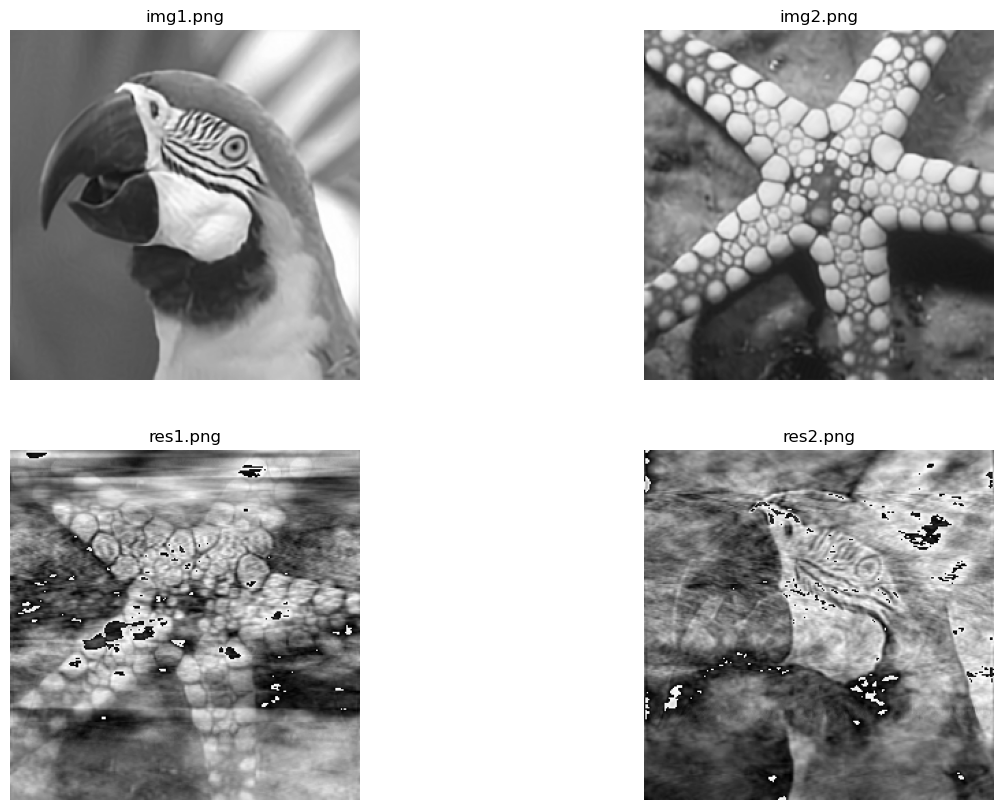

In [4]:
# Función que combina amplitud y fase y regresa la transformada inversa
def combine_and_inverse(amplitude, phase):
    combined_fft = amplitude * np.exp(1j * phase)
    return np.fft.ifft2(combined_fft).real

res1 = combine_and_inverse(amplitude_img1, phase_img2)
res2 = combine_and_inverse(amplitude_img2, phase_img1)

def ShowImageRGB(path):
    # Lee la imagen en color
    image_bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    # Convierte la imagen a RGB
    return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Mostrar las imágenes originales
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0,0].imshow(ShowImageRGB(img1_path))
axes[0,0].set_title('img1.png')
axes[0,0].axis('off')

axes[0,1].imshow(ShowImageRGB(img2_path))
axes[0,1].set_title('img2.png')
axes[0,1].axis('off')

# Imagenes resultantes
axes[1,0].imshow(res1.astype(np.uint8))
axes[1,0].set_title('res1.png')
axes[1,0].axis('off')

axes[1,1].imshow(res2.astype(np.uint8))
axes[1,1].set_title('res2.png')
axes[1,1].axis('off')

plt.show()

Observando los resultados de las imágenes, parece que la cantidad que contiene mas información de la transformada de Fourier es la fase, ya que las imágenes que se formaron de la fase original, fueron las que prevalecieron. Esto puede ser explicado debido a que la fase de cada componente de la frecuencia en la Transformada de Fourier describe el desplazamiento relativo de las ondas sinusoidales que componen la imagen. Por lo tanto, aún cuando la amplitud de estas ondas (que determina la intensidad y contraste) se modifique, mantener la fase permite que la disposición espacial original de la imagen sea reconocible.

## Exercice 2 (Periodic degradation removal) 

The image **img3.png** present a periodic degradation. Construct an image **img3−proc.png** in which this degradation has been removed.

---

Una **degradación periódica** en una imagen es una perturbación que sigue un patrón regular o repetitivo a lo largo de la imagen. Este tipo de degradación puede manifestarse de varias formas, como líneas, rejillas, o cualquier otro patrón geométrico que se repite a intervalos regulares. Para resolver este ejercicio necesitamos identificar las frecuencias que ocasionan que la imagen tenga este tipo de degradación, ya que en el espectro de frecuencia de la imagen, las degradaciones periódicas se manifiestan como picos o puntos brillantes localizados fuera del centro. Podemos eliminar estos picos de frecuencia que son los que ocasionan que nuestra imagen tenga esta degradación periódica. Un filtro ideal para esto es el *filtro elimina banda* o **filtro notch** que filtra señales que están dentro de un rango.

Aplicamos el filtro notch utilizando

In [5]:
# Creación de filtro notch
def notch_reject_filter(shape, d0, u_k, v_k):
    P, Q = shape
    # Initialize filter with zeros
    H = np.zeros((P, Q))

    # Traverse through filter
    for u in range(0, P):
        for v in range(0, Q):
            # Get euclidean distance from point D(u,v) to the center
            D_uv = np.sqrt((u - P / 2 + u_k) ** 2 + (v - Q / 2 + v_k) ** 2)
            D_muv = np.sqrt((u - P / 2 - u_k) ** 2 + (v - Q / 2 - v_k) ** 2)

            if D_uv <= d0 or D_muv <= d0:
                H[u, v] = 0.0
            else:
                H[u, v] = 1.0

    return H

El código del filtro notch se puede encontrar en la [liga](https://stackoverflow.com/questions/65483030/notch-reject-filtering-in-python)

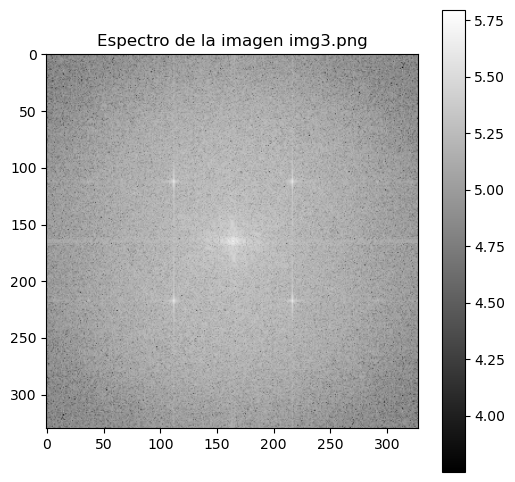

In [6]:
# Cargamos la imagen original
img3_path = glob.glob('/Users/guillermo_sego/Desktop/Segundo Semestre/CVision/Tarea 6/img3.png')[0]

img3 = cv2.imread(img3_path, 0) # Cargamos la imagen en escala de grises

# Aplicamos la transformada de Fourier
fft_img3 = np.fft.fft2(img3)
fft_shifted_img3 = np.fft.fftshift(fft_img3) # Centramos la transformada

# Fase y amplitud
magnitude_img3 = 20*np.log(np.abs(fft_shifted_img3))
phase_img3 = np.angle(fft_shifted_img3)

# Mostramos el espectro de la imagen
plt.figure(figsize=(6, 6))
plt.imshow(np.log(1 + magnitude_img3), cmap='gray')
plt.title('Espectro de la imagen img3.png')
plt.colorbar()
plt.show()

Identificamos 4 puntos principales que son los que están ocasionando el ruido en la imagen. Utilizamos el filtro notch para eliminarlos

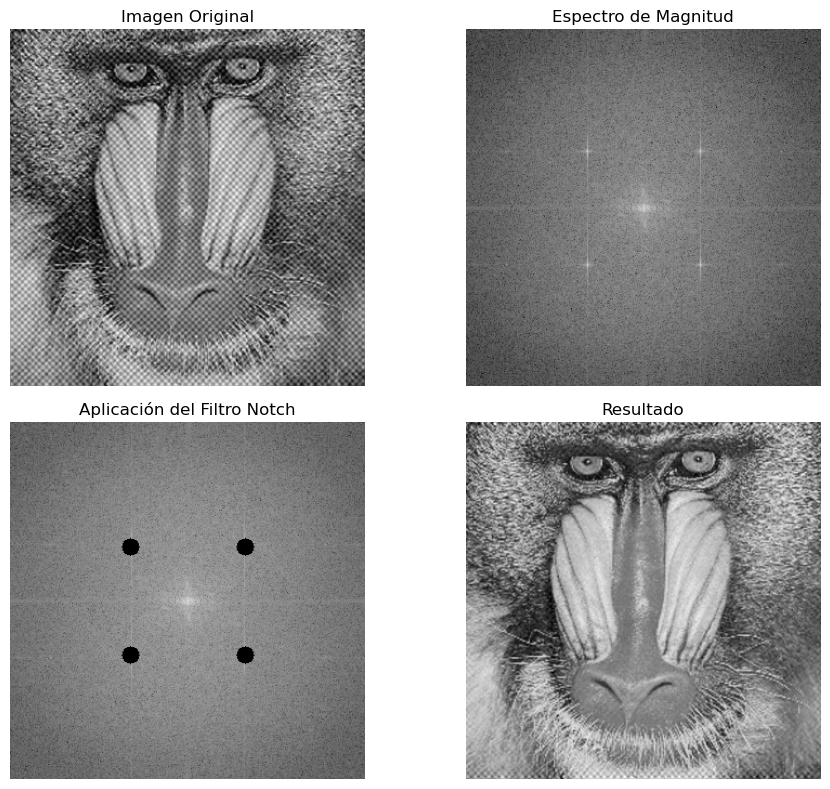

In [7]:
img3_shape = img3.shape

# Creamos el filtro notch
H1 = notch_reject_filter(img3_shape, 8, 50, 53)
H2 = notch_reject_filter(img3_shape, 8, -50, 53)

# Aplicamos el filtro notch
NotchFilter = H1 * H2 
NotchRejectCenter = fft_shifted_img3 * NotchFilter
NotchReject = np.fft.ifftshift(NotchRejectCenter)
inverseNotchReject = np.fft.ifft2(NotchReject)  # Transformada inversa

Result = np.abs(inverseNotchReject)

# Configuración de la visualización de las imágenes
plt.figure(figsize=(10, 8))  # Ajustar el tamaño de la figura según sea necesario

# Imagen original
plt.subplot(2, 2, 1)
plt.imshow(img3, cmap='gray') 
plt.title('Imagen Original')
plt.axis('off')  # Ocultar los ejes

# Espectro de magnitud original
plt.subplot(2, 2, 2)
plt.imshow(magnitude_img3, cmap='gray')  # Asumiendo que magnitude_img3 ya está calculada
plt.title('Espectro de Magnitud')
plt.axis('off')

# Espectro de magnitud con filtro notch aplicado
plt.subplot(2, 2, 3)
plt.imshow(NotchFilter * magnitude_img3, cmap='gray')
plt.title('Aplicación del Filtro Notch')
plt.axis('off')

# Resultado de la imagen procesada
plt.subplot(2, 2, 4)
plt.imshow(Result, cmap='gray')
plt.title('Resultado')
plt.axis('off')

plt.tight_layout() 
plt.show()

## Exercice 3. (Image enhancement).

Let $u_0: \Omega \subset \mathbb{R}^2 \longrightarrow \mathbb{R}^n, n \geq 1$, be a continuous function, and the functional $E$ given by
$$
E(u)=\int_{\Omega} \frac{1}{2}\left\|u(x)-u_0(x)\right\|^2 d x-\frac{\gamma}{4} \int_{\Omega} \int_{\Omega} w(x-y)\|u(x)-u(y)\|^2 d x d y,
$$
where $w$ is a normalized Gaussian kernel of standard deviation $\sigma$. It can be shown that $E$ possesses an unique minimum if $\gamma$ is not too high.
1. Determine an expression of the minimum of the functional $E$.
2. Implement the expression found in 1. and apply it to enhance simultaneously the details and the global contrast of img4.png.

Parameters of the models :
- Details enhancement model : $\gamma_1=0.5$ and $\sigma_1=5$.
- Global contrast enhancement model : $\gamma_2=0.75$ and $\sigma_2=300$.

Hint : You can use the implementation of the 2D Gaussian kernel in gaussian_kernel.py.

---

Tenemos un funcional que necesitamos minimizar, la respuesta directa es utilizar las ecuaciones de Euler-Lagrange. 

$$
\frac{\partial L}{\partial q} - \frac{d}{dt} \frac{\partial L}{\partial \dot{q}} = 0 
$$

Sustituyendo el funcional en la ecuación de Euler-Lagrange, como no hay términos de la derivada de $u$, entonces simplemente se reduce a derivar la parte izquierda de la ecuación

$$
\frac{\partial}{\partial u} \left( \frac{1}{2} \|u(x) - u_0(x)\|^2 \right) - \frac{\gamma}{4} \frac{\partial}{\partial u} \left( \int_{\Omega} w(x-y) \|u(x) - u(y)\|^2 dy \right) = 0
$$

donde $w$ es un kernel gaussiano. Para encontrar el mínimo consideramos la variación de $\delta E(u)$ con respecto a $u$ y la igualamos a cero. 

Derivamos el primer término
$$
\frac{\partial}{\partial u} \left( \frac{1}{2} \|u(x) - u_0(x)\|^2 \right) = u(x) - u_0(x)
$$

Ahora el segundo término
$$
\frac{\partial}{\partial u} \left( \int_{\Omega} w(x-y) \|u(x) - u(y)\|^2 dy \right) = 2 \int_{\Omega} w(x-y) (u(x) - u(y)) dy
$$

Si combinamos las dos expresiones (multiplicando por el factor que contiene a gamma además)
$$
u(x) - u_0(x) - \frac{\gamma}{2} \int_{\Omega} w(x-y) (u(x) - u(y)) dy = 0
$$

se sigue despejando para $u(x)$

$$
u(x) - u_0(x) - u(x) \frac{\gamma}{2} \int_{\Omega} w(x-y) +  \frac{\gamma}{2} \int_{\Omega} w(x-y) u(y) dy = 0
$$

$$
u(x) = \frac{u_0(x) - \frac{\gamma}{2} \int_{\Omega} w(x-y) u(y) dy}{1 - \frac{\gamma}{2} \int_{\Omega} w(x-y) dy}
$$

Debido a que $w$ esta normalizado, $\int_{\Omega} w(x-y) dy = 1$. Entonces finalmente encontramos que la expresión que minimiza el funcional es:
$$
u(x) = \frac{u_0(x) - \frac{\gamma}{2} \int_{\Omega} w(x-y) u(y) dy}{1 - \frac{\gamma}{2}}
$$

Implementamos este algoritmo utilizando una función

Mejora de imagen con gamma = 0.5 y sigma = 5


/var/folders/9t/s_zg1kn954l26k1btcnp7lfm0000gn/T/ipykernel_11091/1401913624.py:2: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gaussian_kernel_1d_1 = np.expand_dims(signal.gaussian(u.shape[0],sigma),axis=1)
/var/folders/9t/s_zg1kn954l26k1btcnp7lfm0000gn/T/ipykernel_11091/1401913624.py:3: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gaussian_kernel_1d_2 = np.expand_dims(signal.gaussian(u.shape[1],sigma),axis=1)


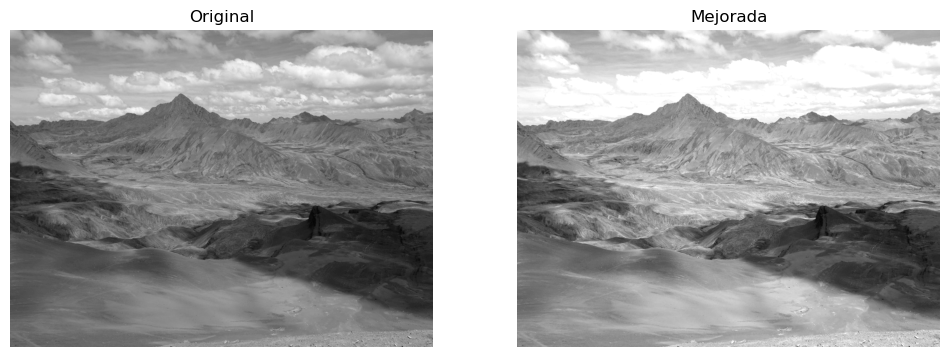

Mejora de imagen con gamma = 0.75 y sigma = 300


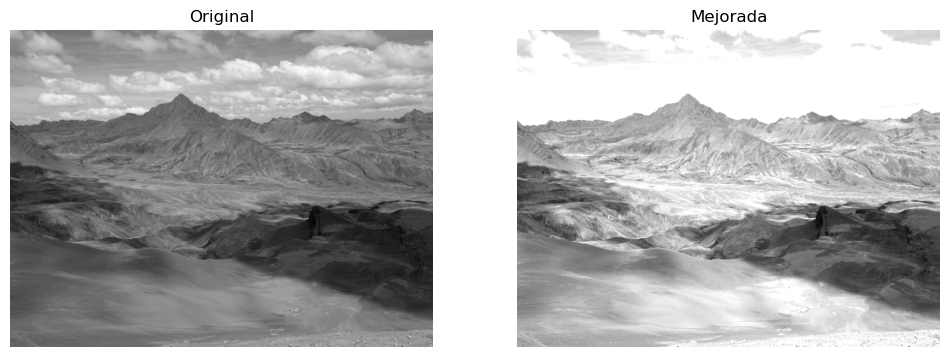

In [25]:
def gaussian_kernel(u,sigma):
	gaussian_kernel_1d_1 = np.expand_dims(signal.gaussian(u.shape[0],sigma),axis=1)
	gaussian_kernel_1d_2 = np.expand_dims(signal.gaussian(u.shape[1],sigma),axis=1)
	gaussian_kernel_2d = np.matmul(gaussian_kernel_1d_1,np.transpose(gaussian_kernel_1d_2))
	gaussian_kernel_2d = gaussian_kernel_2d/np.sum(gaussian_kernel_2d)
	return gaussian_kernel_2d

def enhance_image(image_path, gamma, sigma):
    # Cargar imagen
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Normalizamos la imagen
    u0 = img / 255.0
    
    # Creamos un kernel gaussiano
    ksize = int(6 * sigma + 1)  # Tamaño del kernel
    gauss_kernel = gaussian_kernel(np.zeros((ksize, ksize)), sigma)
    gauss_kernel = gauss_kernel * gauss_kernel.T

    # Realizar la convolución con el kernel gaussiano
    smoothed = cv2.filter2D(u0, -1, gauss_kernel)
    
    # Calcular la imagen mejorada con la expresión obtenida
    u = (u0 - gamma/2 * smoothed) / (1 - gamma/2)
    
    # Escalar la imagen a 0-255
    u_enhanced = np.clip(u * 255, 0, 255).astype(np.uint8)
    
    # Mostrar las imágenes
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(u_enhanced, cmap='gray')
    plt.title('Mejorada')
    plt.axis('off')
    plt.show()

# Prueba de la función de mejora de imagen

img4_path = glob.glob('/Users/guillermo_sego/Desktop/Segundo Semestre/CVision/Tarea 6/img4.png')[0]

print('Mejora de imagen con gamma = 0.5 y sigma = 5')
enhance_image(img4_path, 0.5, 5)  

print('Mejora de imagen con gamma = 0.75 y sigma = 300')
enhance_image(img4_path, 0.75, 300) 


Mejora bastante bien el contrate con los parámetros $\sigma = 0.5$ y $\gamma = 5$. En la segunda imagen el contraste aumenta aún mas pero también lo hace la luminosidad. Es importante encontrar un equilibrio en estos parámetros según lo que se quiera observar.  

## Exercice 4 (Shape classification).

The numpy array shapes.npy, of size 25 × 201 × 2, contains a set of 25 closed curves in $R^2$, each one of them being discretized with 201 points. Figure 0.1 shows 5 curves in the set. Each of the 20 other curves is obtained by applying a translation, a rotation and a scale transformation to one of these 5 curves. The aim of this exercise is to classify automatically the set of 25 curves into 5 classes, each class containing the curves which are deduced from each others by a translation, a rotation and a scale transformation. We know that the method of Fourier descriptors can be used to solve this classification problem.

1. Show that the Fourier descriptors are invariant to translations, rotations and scales.
2. Implement a method which, given a curve, returns its Fourier descriptors.
3 Apply the K-Means method to the Fourier descriptors to generate the 5 classes [link](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). For each class, determine the curves which belong to the class (you can determine a curve by its index in shapes.npy).
4. Let us consider the 2D curve new−shape.npy which does not belong to the dataset. By using the function predict of sklearn.cluster.KMeans, determine the class the curve belongs to.

---

El método de los descriptores de Fourier es una técnica súper útil para clasificación y reconocimiento de formas. Estos *descriptores*, derivados de la transformada de Fourier, permiten representar de manera compacta la forma de un objeto, capturando información geométrica que puede ser utilizada para comparar y clasificar objetos basados en sus contornos.

Los **descriptores de Fourier** se obtienen aplicando la Transformada de Fourier a una representación de contorno de un objeto. Para clasificar formas usando descriptores de Fourier, necesitamos hacer lo siguiente:

1. **Extracción de Descriptores**: Calcular los descriptores de Fourier para cada objeto.
2. **Normalización**: Normalizar para lograr invariancia ante cambios de escala, rotación y traslación. 
3. **Comparación**: Necesitamos comparar los descriptores de Fourier con los descriptores de formas conocidas.
4. **Decisión**: Asignar la categoría de la forma conocida más cercana a la forma desconocida.

In [32]:
def compute_fourier_descriptors(points):
    # Convertir puntos a números complejos
    complex_points = points[:, 0] + 1j * points[:, 1]
    
    # Calcular la Transformada de Fourier Discreta (DFT)
    descriptors = np.fft.fft(complex_points)
    
    # Normalizar descriptores para invarianza de escala
    descriptors /= np.abs(descriptors[1])  # Normalizar por el primer coeficiente no nulo
    
    # Usar la magnitud para invarianza de rotación y escala
    magnitudes = np.abs(descriptors)
    
    return magnitudes

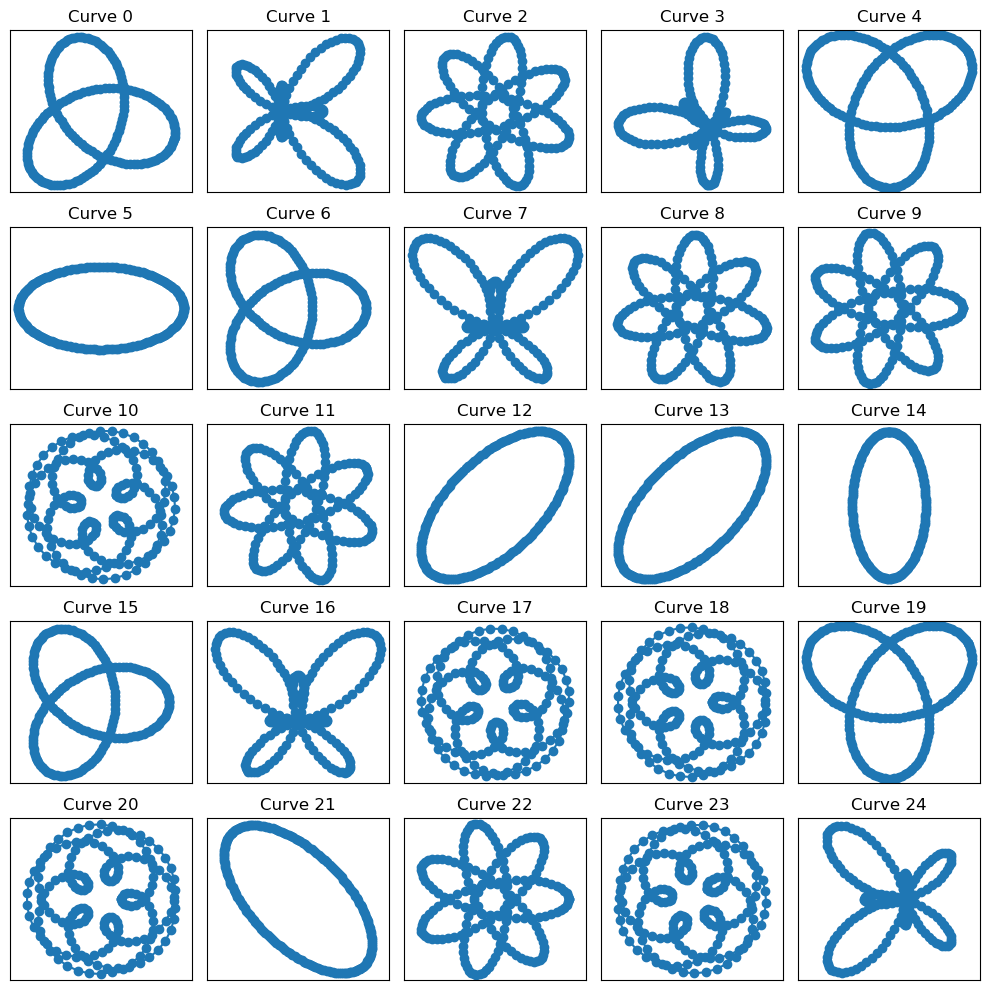

Curvas en la clase 0: [18 20 23]
Curvas en la clase 1: [ 0  4 11]
Curvas en la clase 2: [ 1  2  3  5  6  7  9 12 13 14 15 19 21 22 24]
Curvas en la clase 3: [10 17]
Curvas en la clase 4: [ 8 16]


/Users/guillermo_sego/anaconda3/envs/Vision/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [38]:
# Función para visualizar las curvas
def plot_curves(shapes):
    plt.figure(figsize=(10, 10))
    for i, shape in enumerate(shapes):
        plt.subplot(5, 5, i + 1)  
        plt.plot(shape[:, 0], shape[:, 1], marker='o')
        plt.title(f"Curve {i}")
        plt.axis('equal') 
        plt.xticks([])  # Ocultar marcas en x
        plt.yticks([])  # Ocultar marcas en y
    plt.tight_layout()
    plt.show()

# Leer arreglo de numpy con los shapes
shapes = np.load('/Users/guillermo_sego/Desktop/Segundo Semestre/CVision/Tarea 6/shapes.npy')

# Visualizar las curvas
plot_curves(shapes)

# Calcular los descriptores de Fourier para cada curva
descriptors = np.array([compute_fourier_descriptors(shape) for shape in shapes])

# Aplicar el agrupamiento K-Means
kmeans = KMeans(n_clusters=5, random_state=0).fit(descriptors)

# Imprimir los índices de las curvas en cada grupo
for i in range(5):
    print(f"Curvas en la clase {i}: {np.where(kmeans.labels_ == i)[0]}")

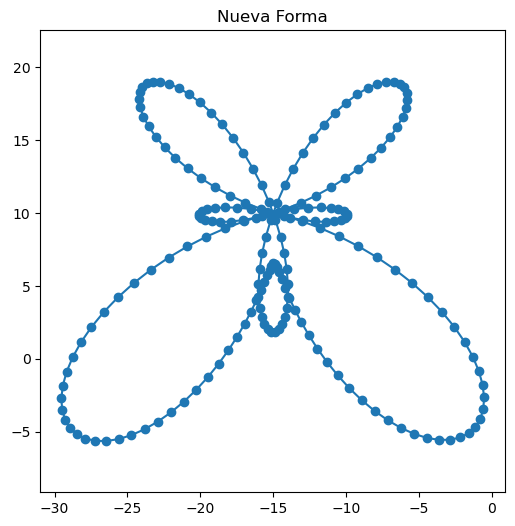

La nueva curva pertenece a la clase: 2


In [37]:
# Cargar la nueva forma
new_shape = np.load('/Users/guillermo_sego/Desktop/Segundo Semestre/CVision/Tarea 6/new_shape.npy')
new_descriptors = compute_fourier_descriptors(new_shape)  # Calcular sus descriptores de Fourier

# Mostrar forma nueva
plt.figure(figsize=(6, 6))
plt.plot(new_shape[:, 0], new_shape[:, 1], marker='o')
plt.title('Nueva Forma')
plt.axis('equal')
plt.show()

# Predecir la clase de la nueva forma
predicted_class = kmeans.predict([new_descriptors])
print(f"La nueva curva pertenece a la clase: {predicted_class[0]}")